**Dataset**
labeled datasset collected from Spotify (Assignment 1 - Spotify Reviews Rating)

**Objective**
classify Review to a category from 1 to 5. <br>

**Total Estimated Time = 90-120 Mins**

**Evaluation metric**
macro f1 score

### Import used libraries

In [76]:
import pandas as pd 
import numpy as np 
import nltk
import matplotlib.pyplot as plt 
import seaborn as sns 
import re 
import string
import contractions 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder 
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import xgboost as xgb
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, classification_report , confusion_matrix

In [2]:
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True) 

True

### Load Dataset

In [3]:
pd.set_option('display.max_rows' , 500)
pd.set_option('display.max_colwidth' ,500)

In [4]:
data = pd.read_csv('Assignment 1 - Spotify Reviews Rating.csv')

In [5]:
data.head()

,Time_submitted,Review,Rating
0,7/9/2022 15:00,"Great music service, the audio is high quality and the app is easy to use. Also very quick and friendly support.",5
1,7/9/2022 14:21,Please ignore previous negative rating. This app is super great. I give it five stars+,5
2,7/9/2022 13:27,"This pop-up ""Get the best Spotify experience on Android 12"" is too annoying. Please let's get rid of this.",4
3,7/9/2022 13:26,Really buggy and terrible to use as of recently,1
4,7/9/2022 13:20,Dear Spotify why do I get songs that I didn't put on my playlist??? And why do we have shuffle play?,1


### Data splitting

It is a good practice to split the data before EDA helps maintain the integrity of the machine learning process, prevents data leakage, simulates real-world scenarios more accurately, and ensures reliable model performance evaluation on unseen data.

In [10]:
X = data['Review']
y = data['Rating']

In [11]:
X_train , X_test , y_train , y_test = train_test_split(X , y)

In [12]:
X_train.shape , X_test.shape , y_train.shape , y_test.shape

((46043,), (15348,), (46043,), (15348,))

### EDA on training data

- check NaNs

In [6]:
data.isna().sum()

Time_submitted    0
Review            0
Rating            0
dtype: int64

- check duplicates

In [7]:
data.drop(columns='Time_submitted' , axis=1 , inplace=True)

In [8]:
data.duplicated().value_counts()

False    61391
True       203
Name: count, dtype: int64

In [9]:
data.drop_duplicates(inplace=True)

- show a representative sample of data texts to find out required preprocessing steps

In [14]:
X_train[np.random.randint(0,len(X_train))]

'Android user - there are loads of glitches with this app... player bar disappears, shuffle button missing....sort it out please'

- check dataset balancing

/tmp/ipykernel_1477/394549087.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data , x='Rating' , palette= sns.color_palette('flare'));
/tmp/ipykernel_1477/394549087.py:1: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.countplot(data , x='Rating' , palette= sns.color_palette('flare'));


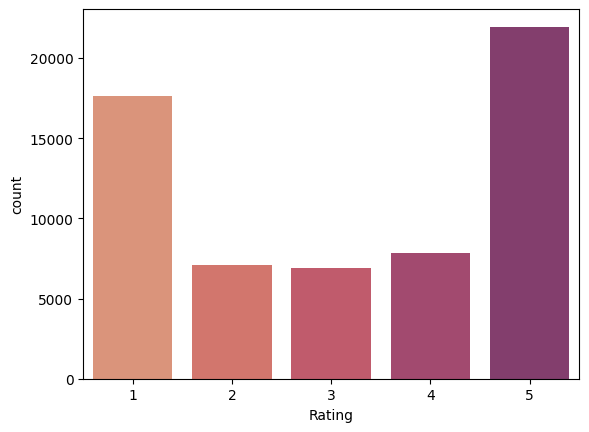

In [15]:
sns.countplot(data , x='Rating' , palette= sns.color_palette('flare'));

**Data is quite balanced**

- Cleaning and Preprocessing are:
    - 1 lower case 
    - 2 remove punctuation & stopwords 
    - 3 lemmetization
    - 4 remove contractions
    - ... etc.

### Cleaning and Preprocessing

In [16]:
def preprocessing(text):
    '''
    this function preprocess text by :
    1- lower case the text 
    2- remove stop-words 
    3- remove contractions 
    4- remove punctuation using re module 
    5- lemmetize text with WorldNetlemmetizer 
    --------------------------
    parameters : 
    text from training set 
    -------------------------
    retruns:
    preprocessed text 
    
    '''
    stop_words = set(nltk.corpus.stopwords.words('english'))
    lemmetizer = WordNetLemmatizer()
    
    text =  text.lower()
    
    #remove contractions before punctuation
    text = contractions.fix(text)
    
    #text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub('[^a-z A-Z 0-9-]+','', text)
    
    tokens = nltk.word_tokenize(text)
    
    #removing stop words before lemmetizing 
    tokens = [word for word in tokens if word not in stop_words ]
    tokens = [lemmetizer.lemmatize(word) for word in tokens]
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text 

In [17]:
X_train.head(3)

59834                                                                                                                                                                                                                                                                                                                                                                                 I love it it has so many songs to choose from and its random even on your playlist I love it if recommend using it
39250    Ok so I use spotify almost every day and I usually never have any problems. However, recently, I've been having a problem where I basically cannot access the blended playlists that I've made wi some friends The screen is black save for the bar at the bottom and whatever song I was previously listening to. From there it is impossible to do anything on the app. It does revert back until I've closed the app and have waited for my phone to tell me that Spotify is not responding.
16672                 

In [18]:
preprocessed_X = X_train.apply(preprocessing)
preprocessed_X.head(3)

59834                                                                                                                                                                                                                        love many song choose random even playlist love recommend using
39250    ok use spotify almost every day usually never problem however recently problem basically access blended playlist made wi friend screen black save bar bottom whatever song previously listening impossible anything app revert back closed app waited phone tell spotify responding
16672                                                                                                                                                                                                                                                                   best music app india
Name: Review, dtype: object

**You  are doing Great so far!**

### Modelling
    _apply transformation on both X_train & X_test 
    _spliting data to mini_batches with Batch_size = 64

#### Count Vectorizing 

In [19]:
count_vec = CountVectorizer()
count_vec.fit(preprocessed_X) 

CountVectorizer()

In [20]:
X_train_cv = count_vec.transform(preprocessed_X)
X_test_cv = count_vec.transform(X_test)  

#### TF_IDF 

In [22]:
tfidf = TfidfVectorizer(ngram_range=(1,2))
tfidf.fit(preprocessed_X)

TfidfVectorizer(ngram_range=(1, 2))

In [23]:
X_train_tfidf = tfidf.transform(preprocessed_X)
X_test_tfidf = tfidf.transform(X_test)

In [24]:
def mini_batches(X , y , batch_size):
    '''
    creates mini_batches with chosen batch_size 
    -----------------------------------------
    parameters :
    X : data points to be split 
    y : target data points 
    -----------------------------------------
    returns :
    X_mini_batchs , y_mini_batchs
    
    '''
    X_mini_batches = []
    y_mini_batches = []
    
    no_batches = X.shape[0] // batch_size
    
    if X.shape[0] % batch_size != 0 :
        no_batches += 1 
        
    for i in range(0 , no_batches):
        X_mini_batch = X[i*batch_size: (i+1)*batch_size]
        y_mini_batch = y[i*batch_size : (i+1)*batch_size]
        
        X_mini_batches.append(X_mini_batch)
        y_mini_batches.append(y_mini_batch)
        
    return X_mini_batches , y_mini_batches

#### LogisticRegression  _ Count Vectorizer

In [32]:
X_mini_batches_cv , y_mini_batches_cv = mini_batches(X_train_cv , y_train , 64)

In [26]:
lr_model_cv = LogisticRegression()

In [27]:
for X_mini_batch , y_mini_batch in zip(X_mini_batches ,y_mini_batches):
    lr_model_cv.fit(X_mini_batch , y_mini_batch)

#### LogisticRegression _ TF_IDF 

In [33]:
X_mini_batches , y_mini_batches = mini_batches(X_train_tfidf , y_train , 64)

In [29]:
lr_model_tfidf = LogisticRegression()

In [30]:
for X_mini_batch , y_mini_batch in zip(X_mini_batches ,y_mini_batches):
    lr_model_tfidf.fit(X_mini_batch , y_mini_batch)

#### MultinomialNB _ Count vectorizer 

In [36]:
mn_model_cv = MultinomialNB()

In [37]:
for X_mini_batch , y_mini_batch in zip(X_mini_batches_cv ,y_mini_batches_cv):
    mn_model_cv.fit(X_mini_batch , y_mini_batch)

#### MultinomialNB _ Tf-IDF 

In [38]:
mn_model_tfidf = MultinomialNB()

In [39]:
for X_mini_batch , y_mini_batch in zip(X_mini_batches ,y_mini_batches):
    mn_model_tfidf.fit(X_mini_batch , y_mini_batch)

#### Model Results 

In [40]:
lr_model_cv_score = lr_model_cv.score(X_test_cv , y_test)
print(f'LinearRegression_Count Vector score:{lr_model_cv_score}')

LinearRegression_Count Vector score:0.42520198071409954


In [43]:
lr_model_tfidf_score = lr_model_tfidf.score(X_test_tfidf , y_test)
print(f'LinearRegression_TF-IDF Vector score:{lr_model_tfidf_score}')

LinearRegression_TF-IDF Vector score:0.3614151681000782


In [44]:
mn_model_cv_score = mn_model_cv.score(X_test_cv , y_test)
print(f'Multinomial_Count Vector score:{mn_model_cv_score}')

Multinomial_Count Vector score:0.4901615845712796


In [45]:
mn_model_tfidf_score = mn_model_tfidf.score(X_test_tfidf , y_test)
print(f'Multinomial_Count Vector score:{mn_model_tfidf_score}')

Multinomial_Count Vector score:0.3614151681000782


In [46]:
y_pred_cv = lr_model_cv.predict(X_test_cv) 
y_pred_tfidf = lr_model_tfidf.predict(X_test_tfidf)

In [47]:
y_pred_cv_mn = mn_model_cv.predict(X_test_cv)
y_pred_tfidf_mn = mn_model_tfidf.predict(X_test_tfidf) 

#### Evaluation

**Evaluation metric:**
macro f1 score

Macro F1 score is a useful metric in scenarios where you want to evaluate the overall performance of a multi-class classification model, **particularly when the classes are imbalanced**

![Calculation](https://assets-global.website-files.com/5d7b77b063a9066d83e1209c/639c3d934e82c1195cdf3c60_macro-f1.webp)

In [49]:
f1_score(y_test,y_pred_cv , average='macro') 

0.19290881508320862

In [50]:
f1_score(y_test , y_pred_tfidf , average= 'macro')

0.10618808327351041

In [51]:
f1_score(y_test , y_pred_cv_mn , average='macro') 

0.2517640468447038

In [52]:
f1_score(y_test , y_pred_tfidf_mn , average= 'macro')

0.10619316550205801

In [55]:
print(classification_report( y_test , y_pred_cv_mn))

              precision    recall  f1-score   support

           1       0.41      0.77      0.54      4379
           2       0.00      0.00      0.00      1792
           3       0.18      0.02      0.03      1693
           4       0.18      0.02      0.03      1937
           5       0.59      0.74      0.66      5547

    accuracy                           0.49     15348
   macro avg       0.27      0.31      0.25     15348
weighted avg       0.38      0.49      0.40     15348



/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

### Enhancement

**it turns out that Multinomial with Count Vectorizer became with better results so we will try to enhance it**

In [56]:
count_vec_2 = CountVectorizer(ngram_range=(1,3))

In [57]:
X_train_cv_2 = count_vec_2.fit(preprocessed_X )

In [60]:
X_train_cv_2 = count_vec_2.transform(preprocessed_X)
X_test_cv_2 = count_vec_2.transform(X_test)

In [58]:
mn_model_cv_2 = MultinomialNB()

In [61]:
mn_model_cv_2.fit(X_train_cv_2 , y_train)

MultinomialNB()

In [64]:
mn_model_cv_score_2 = mn_model_cv_2.score(X_test_cv_2 ,y_test)
mn_model_cv_score_2 

0.5812483711232734

In [65]:
y_pred_2  = mn_model_cv_2.predict(X_test_cv_2)

In [67]:
f1_score(y_test , y_pred_2 , average= 'macro') 

0.29703984730591027

In [68]:
print(classification_report(y_test , y_pred_2))

              precision    recall  f1-score   support

           1       0.50      0.88      0.64      4379
           2       0.26      0.01      0.01      1792
           3       0.25      0.01      0.01      1693
           4       0.37      0.03      0.05      1937
           5       0.67      0.90      0.77      5547

    accuracy                           0.58     15348
   macro avg       0.41      0.36      0.30     15348
weighted avg       0.49      0.58      0.47     15348



### Conclusion and final results


**changing N_grams range with Multinomial naïve base classifier came with better results**

#### Done!

## Trying different approach 

In [69]:
def Categories(rating):
    '''
    split ratings into categories
    '''
    if rating == 5  or rating == 4 :
        return 'Good'
    elif rating == 3 :
        return 'Intermediate'
    elif rating == 1 :
        return 'Bad' 

In [70]:
data['Rating'] = data['Rating'].apply(Categories) 

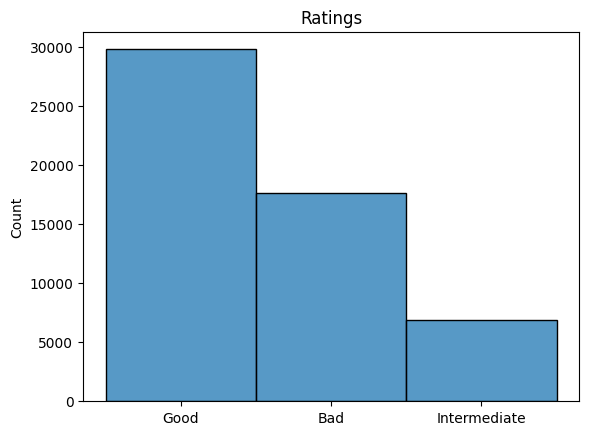

In [73]:
sns.histplot(data['Rating'])
plt.title('Ratings')
plt.xlabel('')
plt.show() 

#### splitting the data again 

In [74]:
X = data['Review'] 
y = data['Rating'] 

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=40)
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((46043,), (15348,), (46043,), (15348,))

In [77]:
label_encoder = LabelEncoder()

In [78]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

In [79]:
count_vec_3 = CountVectorizer()
count_vec_3.fit(X_train)
X_train_cv = count_vec_3.transform(X_train)
X_test_cv = count_vec_3.transform(X_test) 

In [81]:
mn_model_cv_3 = MultinomialNB()
mn_model_cv_3.fit(X_train_cv, y_train)

MultinomialNB()

In [83]:
mn_model_cv_score_3 = mn_model_cv_3.score(X_test_cv, y_test)
print(f'Multinomial Naive Bayes Classifier score : {mn_model_cv_score_3}') 

Multinomial Naive Bayes Classifier score : 0.677547563200417


In [85]:
y_pred_3 = mn_model_cv_3.predict(X_test_cv)

In [87]:
f1_score(y_test , y_pred_3 , average='macro') 

0.4610578946284947

In [89]:
print(classification_report(y_test , y_pred_3))

              precision    recall  f1-score   support

           0       0.58      0.81      0.67      4366
           1       0.83      0.86      0.85      7492
           2       0.29      0.12      0.17      1719
           3       0.26      0.11      0.16      1771

    accuracy                           0.68     15348
   macro avg       0.49      0.48      0.46     15348
weighted avg       0.63      0.68      0.64     15348

